In [1]:
!pip install nltk


In [2]:
# 1. IMPORTS & CONFIGURATION
# ==========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import nltk
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence
from tqdm import tqdm

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# ==========================================
# STEP 4: VOCABULARY & DATASET CLASSES
# ==========================================

# Configuration for Kaggle Paths
DATA_DIR = "/kaggle/input/flickr8k" 
IMAGE_DIR = os.path.join(DATA_DIR, "Images")
CAPTION_FILE = os.path.join(DATA_DIR, "captions.txt")

# Hyperparameters for Data
BATCH_SIZE = 64
NUM_WORKERS = 4
VOCAB_THRESHOLD = 5

class Vocabulary:
    def __init__(self, freq_threshold):
        # Define special tokens
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.lower() for tok in str(text).split()]

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                frequencies[word] += 1
                
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        
        # Get image paths and captions
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        # Initialize vocabulary and build it
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        # Convert caption to indices: <SOS> + numericalized caption + <EOS>
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        # Add dimension for batching
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        # Pad sequences to the same length within the batch
        targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        return imgs, targets

# Define Image Transforms (Resize, Crop, Normalize)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Initialize Dataset and DataLoader
print("Loading Dataset (this might take a minute to build vocab)...")
dataset = FlickrDataset(root_dir=IMAGE_DIR, captions_file=CAPTION_FILE, transform=transform, freq_threshold=VOCAB_THRESHOLD)
pad_idx = dataset.vocab.stoi["<PAD>"]

loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    pin_memory=True,
    collate_fn=Collate(pad_idx=pad_idx),
)

vocab_size = len(dataset.vocab)
print(f"Dataset loaded successfully! Vocabulary Size: {vocab_size}")

Loading Dataset (this might take a minute to build vocab)...
Dataset loaded successfully! Vocabulary Size: 3005


In [5]:
# ==========================================
# STEP 5: MODEL ARCHITECTURE
# ==========================================

# Configuration for Model Dimensions
EMBED_SIZE = 512
ATTENTION_DIM = 512
DECODER_DIM = 512
LEARNING_RATE = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(EncoderCNN, self).__init__()
        # Load EfficientNet-B3 with default pre-trained weights
        efficientnet = models.efficientnet_b3(weights='DEFAULT')
        
        # We only need the feature extraction part, not the classification head
        self.features = efficientnet.features 
        
        # Fine-Tuning Strategy: Freeze early layers, unfreeze later ones
        # This speeds up training and saves memory
        for param in self.features.parameters():
            param.requires_grad = False 
        
        # Ensure output is a fixed grid size (e.g., 14x14) for attention
        self.encoded_image_size = encoded_image_size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

    def forward(self, images):
        # Extract features
        features = self.features(images)  # Shape: (batch, 1536, H, W)
        features = self.adaptive_pool(features) # Shape: (batch, 1536, 14, 14)
        features = features.permute(0, 2, 3, 1) # Shape: (batch, 14, 14, 1536)
        return features

class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        # Combine encoder and decoder info to calculate scores
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1)))
        alpha = self.softmax(att)
        # Apply attention weights to encoder output
        attention_weighted_encoding = (encoder_out * alpha).sum(dim=1)
        return attention_weighted_encoding, alpha

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super(DecoderRNN, self).__init__()
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        
        # LSTMCell allows us to run the loop manually step-by-step for attention
        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.dropout = nn.Dropout(drop_prob)

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, captions):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        
        # Flatten image features
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim) 
        num_pixels = encoder_out.size(1)

        embeddings = self.embedding(captions) 
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)

        decode_len = captions.size(1) - 1
        predictions = torch.zeros(batch_size, decode_len, vocab_size).to(DEVICE)
        alphas = torch.zeros(batch_size, decode_len, num_pixels).to(DEVICE)

        for t in range(decode_len):
            # Calculate Attention
            attention_weighted_encoding, alpha = self.attention(encoder_out, h)
            gate = torch.sigmoid(self.f_beta(h))
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            # Concatenate input embedding and context vector
            lstm_input = torch.cat([embeddings[:, t, :], attention_weighted_encoding], dim=1)
            
            # LSTM Step
            h, c = self.lstm_cell(lstm_input, (h, c))
            preds = self.fc(self.dropout(h))
            
            predictions[:, t, :] = preds
            alphas[:, t, :] = alpha.squeeze(2)

        return predictions, alphas

# Initialize Models
# EfficientNet-B3 output channels is 1536
encoder = EncoderCNN().to(DEVICE)
decoder = DecoderRNN(
    embed_size=EMBED_SIZE,
    vocab_size=len(dataset.vocab),
    attention_dim=ATTENTION_DIM,
    encoder_dim=1536, 
    decoder_dim=DECODER_DIM
).to(DEVICE)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(list(decoder.parameters()) + list(encoder.features.parameters()), lr=LEARNING_RATE)

print("Models initialized successfully!")

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 170MB/s]


Models initialized successfully!


In [6]:
# ==========================================
# STEP 6: TRAINING LOOP (CORRECTED)
# ==========================================

EPOCHS = 5
print(f"Starting Training for {EPOCHS} epochs...")

# Set models to training mode
encoder.train()
decoder.train()

for epoch in range(EPOCHS):
    # Initialize progress bar
    loop = tqdm(loader, total=len(loader), leave=True)
    
    for idx, (imgs, captions) in enumerate(loop):
        # Move data to GPU
        imgs = imgs.to(DEVICE)
        captions = captions.to(DEVICE)
        
        # FIX: The DataLoader returns captions as (seq_len, batch_size).
        # The Decoder expects (batch_size, seq_len).
        # We permute dimensions 0 and 1.
        captions = captions.permute(1, 0)

        # Forward Pass
        # 1. Get image features
        features = encoder(imgs)
        
        # 2. Generate predictions
        # We pass the corrected (batch_first) captions here
        outputs, alphas = decoder(features, captions)

        # Calculate Loss
        # Targets: We remove the first token <SOS> from targets because model predicts next word
        # Targets shape: (batch_size, seq_len) -> Slice to remove <SOS>
        targets = captions[:, 1:] 
        
        # Reshape for CrossEntropyLoss
        # outputs shape: (batch_size, seq_len, vocab_size) -> (batch*seq_len, vocab_size)
        # targets shape: (batch_size, seq_len) -> (batch*seq_len)
        
        # Note: Decoder outputs are already one step shorter than captions (no <EOS> prediction for last step input)
        # So outputs length matches targets length (captions - <SOS>)
        
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), targets.reshape(-1))

        # Backward Pass & Optimization
        optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients to prevent exploding gradient problem in LSTMs
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=5.0)
        
        optimizer.step()

        # Update progress bar
        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(loss=loss.item())

    # Save Model Checkpoint after every epoch
    print(f"Saving checkpoint for Epoch {epoch+1}...")
    if not os.path.exists("models_dir"):
        os.makedirs("models_dir")
        
    torch.save(decoder.state_dict(), os.path.join("models_dir", f"decoder_epoch{epoch+1}.pth"))
    torch.save(encoder.state_dict(), os.path.join("models_dir", f"encoder_epoch{epoch+1}.pth"))

print("Training Complete!")

Starting Training for 5 epochs...


Epoch [1/5]: 100%|██████████| 633/633 [06:41<00:00,  1.57it/s, loss=3.01]


Saving checkpoint for Epoch 1...


Epoch [2/5]: 100%|██████████| 633/633 [06:51<00:00,  1.54it/s, loss=2.95]


Saving checkpoint for Epoch 2...


Epoch [3/5]: 100%|██████████| 633/633 [06:52<00:00,  1.54it/s, loss=2.79]


Saving checkpoint for Epoch 3...


Epoch [4/5]: 100%|██████████| 633/633 [06:51<00:00,  1.54it/s, loss=2.64]


Saving checkpoint for Epoch 4...


Epoch [5/5]: 100%|██████████| 633/633 [06:51<00:00,  1.54it/s, loss=2.29]


Saving checkpoint for Epoch 5...
Training Complete!


In [8]:
import torch.nn.functional as F

def beam_search(encoder, decoder, image, vocab, beam_size=3):
    encoder.eval()
    decoder.eval()
    
    k = beam_size
    vocab_size = len(vocab)
    
    # 1. Encode
    image = image.unsqueeze(0).to(DEVICE) # (1, 3, 256, 256)
    encoder_out = encoder(image) # (1, 14, 14, 1536)
    encoder_dim = encoder_out.size(-1)
    
    # Flatten encoder output
    encoder_out = encoder_out.view(1, -1, encoder_dim) # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)
    
    # Expand to beam size
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim) # (k, num_pixels, encoder_dim)
    
    # 2. Init LSTM
    h, c = decoder.init_hidden_state(encoder_out) # (k, decoder_dim)
    
    # 3. Start word
    top_k_prev_words = torch.tensor([vocab.stoi["<SOS>"]] * k).to(DEVICE) # (k)
    
    # Store sequences and scores
    seqs = top_k_prev_words.unsqueeze(1) # (k, 1)
    top_k_scores = torch.zeros(k, 1).to(DEVICE)
    
    # Store complete sequences
    complete_seqs = list()
    complete_seqs_scores = list()
    
    step = 1
    
    with torch.no_grad():
        while True:
            # Embeddings
            embeddings = decoder.embedding(top_k_prev_words) # (k, embed_dim)
            
            # Attention
            attention_weighted_encoding, _ = decoder.attention(encoder_out, h)
            gate = torch.sigmoid(decoder.f_beta(h))
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            # LSTM input
            lstm_input = torch.cat([embeddings, attention_weighted_encoding], dim=1)
            h, c = decoder.lstm_cell(lstm_input, (h, c))
            
            # Prediction
            scores = decoder.fc(h) # (k, vocab_size)
            scores = F.log_softmax(scores, dim=1)
            
            # Add previous scores
            scores = top_k_scores.expand_as(scores) + scores # (k, vocab_size)
            
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
            else:
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)
            
            # Convert flattened indices
            prev_word_inds = top_k_words // vocab_size
            next_word_inds = top_k_words % vocab_size
            
            # Add new words to sequences
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1) # (k, step+1)
            
            # Check for incomplete sequences
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if next_word != vocab.stoi["<EOS>"]]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))
            
            # Save complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            
            k -= len(complete_inds)
            
            if k == 0:
                break
                
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            top_k_prev_words = next_word_inds[incomplete_inds]
            
            if step > 50:
                break
            step += 1
            
    # Find best sequence
    if len(complete_seqs_scores) > 0:
        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i]
    else:
        seq = seqs[0].tolist()
        
    # Decode
    caption = [vocab.itos[idx] for idx in seq if idx not in {vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"]}]
    return " ".join(caption)

Loading the trained model weights...
Generating caption...


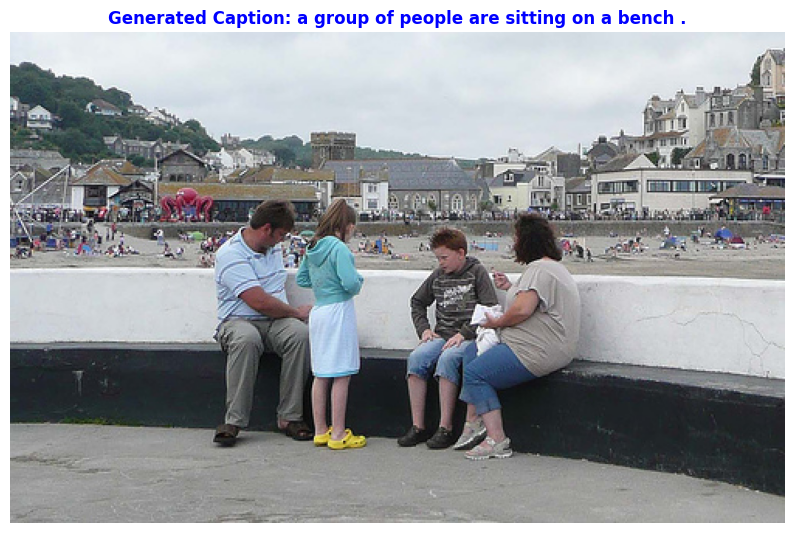

In [12]:
# ==========================================
# STEP 7: TEST THE MODEL
# ==========================================
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Best Saved Weights (Epoch 5)
# This ensures we use the "smartest" version of your model
print("Loading the trained model weights...")
encoder.load_state_dict(torch.load("./models_dir/encoder_epoch5.pth"))
decoder.load_state_dict(torch.load("./models_dir/decoder_epoch5.pth"))

# 2. Switch to Evaluation Mode (Turn off training specific features like Dropout)
encoder.eval()
decoder.eval()

# 3. Pick a Random Image from the Dataset
idx = np.random.randint(0, len(dataset))
img_tensor, _ = dataset[idx]
img_filename = dataset.imgs[idx]

# 4. Generate Caption using Beam Search
# beam_size=5 gives better results than 1 (Greedy search)
print("Generating caption...")
caption = beam_search(encoder, decoder, img_tensor, dataset.vocab, beam_size=5)

# 5. Display the Image and the Caption
# We load the original image again for display clarity (un-normalized)
original_img = Image.open(os.path.join(IMAGE_DIR, img_filename)).convert("RGB")

plt.figure(figsize=(10, 8))
plt.imshow(original_img)
plt.title(f"Generated Caption: {caption}", fontsize=12, color='blue', fontweight='bold')
plt.axis("off")
plt.show()

Generating caption for custom image...


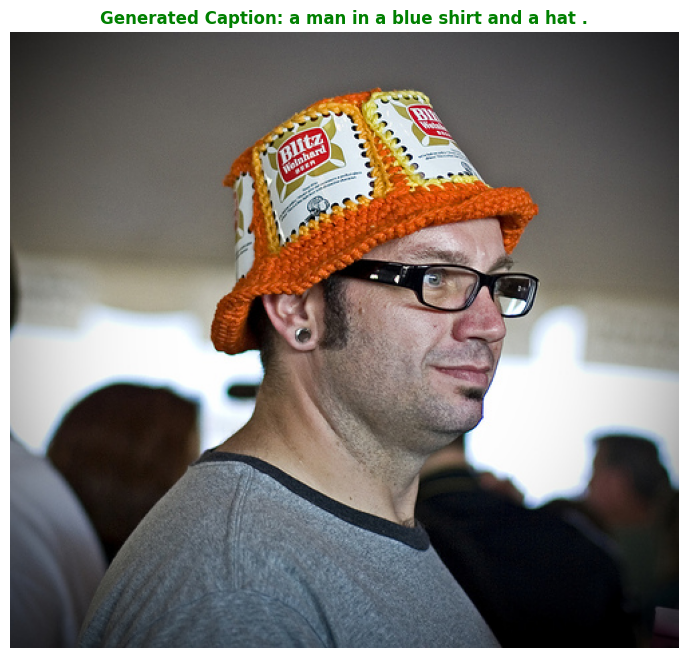

In [20]:
# ==========================================
# TEST ON YOUR OWN CUSTOM IMAGE
# ==========================================
# 1. Define the path to your image
custom_image_path = "/kaggle/input/flickr8k/Images/1007129816_e794419615.jpg" # <--- REPLACE THIS with your image path

# 2. Load and Transform the Image
def load_custom_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    # Apply the same transforms (Resize, Normalize) used during training
    image_tensor = transform(image)
    return image, image_tensor

# Load
original_img, img_tensor = load_custom_image(custom_image_path, dataset.transform)

# 3. Generate Caption
print("Generating caption for custom image...")
caption = beam_search(encoder, decoder, img_tensor, dataset.vocab, beam_size=5)

# 4. Show Result
plt.figure(figsize=(10, 8))
plt.imshow(original_img)
plt.title(f"Generated Caption: {caption}", fontsize=12, color='green', fontweight='bold')
plt.axis("off")
plt.show()